In [205]:
# Import all Math tools:
#-----------------------
import numpy as np
from scipy import integrate
from scipy.spatial.distance import directed_hausdorff
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
# Figure dpi
dpi = 72

## 2) Experiment I: Cobweb of GP Posterior Fit of a 1D Map

### Function Defintions

In [206]:
def GP_Predict_Point(x0):
    Xstar = np.linspace(x0,x0, 1).reshape(-1, 1)
    Ystar, Vstar = m.predict(Xstar)
    Ystar = Ystar[0][0]
    return Ystar

In [207]:
def GP_Predict_Array(X):
    Xstar = np.linspace(X,X, 1).reshape(-1, 1)
    Ystar, Vstar = m.predict(Xstar)
    return Ystar

In [208]:
def plot_cobweb_GP(r0,x0,fig,ax,bx):
    x = Xnew

    # Plot y = f(x) and y = x
    ax.plot(x,mean[:,0],c='#444444',lw=1)
    ax.plot(x, x, c='#444444', lw=1)

    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        Xstar = np.linspace(px[n-1][0],px[n-1][0], 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        Ystar = np.append(Ystar[0],Ystar[0])
        py[n] = Ystar #f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]

    # Plot the path traced out by the iteration.
    ax.plot(px, py, c='b', alpha=0.7, lw=1)

    # Annotate and tidy the plot.
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.5, ls='--')
    ax.grid(which='major', alpha=0.5, ls='--')
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'${one}x(1-x)$'.format(one = r0))
    ax.set_title(r'$x_0 = {one}, r = {two}$'.format(one = x0, two = r0))#ax.set_title(r'$x_0 = {:.1}$'.format(x0))
    ax.set_ylim(bottom=0,top=1.05)
    ax.set_xlim(left=0,right=1.05)


    n = range(0,nmax+1)
    xn = []
    for i in n:
        xn.append(x0)
        Xstar = np.linspace(x0,x0, 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        x0 = Ystar[0][0] #f(x0)
    bx.plot(n, xn, c='b', alpha=0.7, lw=1, ls='-', marker='o')
    bx.minorticks_on()
    bx.grid(which='minor', alpha=0.5, ls='--')
    bx.grid(which='major', alpha=0.5, ls='--')
    bx.set_xlabel(r'$n$')
    bx.set_ylabel(r'$x_n$')
    #bx.set_ylim(bottom=-0.1, top=1.1)
    bx.set_xlim(left=0)

In [209]:
def plot_cobweb_f(r0,x0,fig,ax,bx):
    x = np.linspace(0,1,500)

    # Plot y = f(x) and y = x
    ax.plot(x,f(x),"k:",lw=2)
#     ax.plot(x, x, c='#444444', lw=1)

    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]

    # Plot the path traced out by the iteration.
    ax.plot(px, py, c='tab:orange', alpha=0.7, lw=1)

    # Annotate and tidy the plot.
#     ax.minorticks_on()
#     ax.grid(which='minor', alpha=0.5, ls='--')
#     ax.grid(which='major', alpha=0.5, ls='--')
#     ax.set_aspect('equal')
#     ax.set_xlabel(r'$x$')
#     ax.set_ylabel(r'${one}x(1-x)$'.format(one = r0))
#     ax.set_title(r'$x_0 = {one}, r = {two}$'.format(one = x0, two = r0))#ax.set_title(r'$x_0 = {:.1}$'.format(x0))
#     ax.set_ylim(bottom=0)
#     ax.set_xlim(left=0)


    n = range(0,nmax+1)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    bx.plot(n, xn, c='tab:orange', alpha=0.7, lw=1, ls='-', marker='o')
#     bx.minorticks_on()
#     bx.grid(which='minor', alpha=0.5, ls='--')
#     bx.grid(which='major', alpha=0.5, ls='--')
#     bx.set_xlabel(r'$n$')
#     bx.set_ylabel(r'$x_n$')
#     #bx.set_ylim(bottom=-0.1, top=1.1)
#     bx.set_xlim(left=0)

In [210]:
def f_bif(x,r0):
    return r0*x*(1-x)

def plot_bifurcation(r1,r2,fig,ax1):
    n = 10000
    r0 = np.linspace(r1, r2, n)
    iterations = 1000
    last = 100
    x = 1e-5 * np.ones(n)

    for i in range(iterations):
        x = f_bif(x,r0)
        # We display the bifurcation diagram.
        if i >= (iterations - last):
            ax1.plot(r0, x, ',k', alpha=.25, lw=1)
    ax1.set_xlim(r1, r2)
    ax1.set_xlabel("r"), ax1.set_ylabel("x")
    ax1.set_title("Bifurcation diagram of f")
    ax1.minorticks_on()
    plt.tight_layout()

In [211]:
def time_series_dist(x0,N):
    n = range(0,N)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    return np.array(xn)

Declump: Works well for 1D. For higher dimensions (in future experiments), consider this: https://en.wikipedia.org/wiki/Closest_pair_of_points_problem

In [212]:
def declump(X,N,iterations):
    X = np.sort(X.transpose()[0])
    dst_btwn_cnsc_pnts = [np.abs(X[i]-X[i-1]) for i in range(1,len(X))]
    smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
    X = np.delete(X,smllst_dst_index) # delete the left sample point
    
    for i in range(0,iterations-1):
        if smllst_dst_index > 1:
            dst_btwn_cnsc_pnts =  dst_btwn_cnsc_pnts[0:smllst_dst_index-1] + [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        elif smllst_dst_index == 1:
            dst_btwn_cnsc_pnts = [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        else:
            dst_btwn_cnsc_pnts = dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]

        smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
        X = np.delete(X,smllst_dst_index) # delete the left sample point
        
    X = X[:,None]
    N = N - iterations
    return X, N;

In [213]:
import timeit

N = 2000
X = np.linspace(0, 1, N)[:,None]
start_time = timeit.default_timer()
X,N = declump(X,N,1500)
elapsed = timeit.default_timer() - start_time
print(elapsed)

0.24042580000241287


In [254]:
def Get_GP_Orbit_Points(x0,nmax,m):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        Xstar = np.linspace(px[n-1][0],px[n-1][0], 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        Ystar = np.append(Ystar[0],Ystar[0])
        py[n] = Ystar #f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

In [255]:
def Get_f_Orbit_Points(x0,nmax,f):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

In [256]:
def Hausdorff(x0,nmax,m,f):
    GP_X = Get_GP_Orbit_Points(x0,nmax,m)[0].transpose()[0]
    f_X = Get_f_Orbit_Points(x0,nmax,f)[0].transpose()[0]
    GP_Y = Get_GP_Orbit_Points(x0,nmax,m)[1].transpose()[0]
    f_Y = Get_f_Orbit_Points(x0,nmax,f)[1].transpose()[0]
    u = []
    v = []
    for i in range(2*nmax+1):
        u.append((GP_X[i],GP_Y[i]))
        v.append((f_X[i],f_Y[i]))
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

### Experiment Tools

### Setup

#### Background on Time Series
A dynamical system in which time is discrete is called a difference equation, recursion relation, or iterated map. A time series is a series of data points indexed in time. <br>

#### Background on the Logistic Map
(1)<br>
The logistic map is
$$x_{n+1} = rx_n(1-x_n)$$
where $r$ is the bifurcation parameter, which corresponds to the growth rate of the population, and $x_0$ is a dimensionless initial population value. Based on certain values of $r$, the logisitc map behaves differently:
<ul>
    <li>For $r<1$, $x_n\rightarrow 0$ as $n\rightarrow \infty$.</li>
    <li>For $1<r<3$, the population approaches a nonzero steady state.</li>
    <li>For $r=3.3$, the map becomes a period-2 cycle, undergoing its first period doubling.</li>
    <li>For $r>r_\infty$, $x_n$ never stabilizes to a fixed point or cycle and the map is chaotic.</li>
</ul>
(/1)
<br>
(1) Steven Strogatz; Nonlinear Dynamics and Chaos with Applications to Physics, Biology, Chemistry, and Engineering

In [268]:
# 1) Choose the kernel. Construct the 1D RBF kernel:
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")

# 2) Choose function and r-value. lambda function, call f(x) to generate data
r = 2
f = lambda x: r*x*(1-x)  #-np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 3) Choose number of sample locations
N = 10

# 4) Choose domain of sample points.
#X = np.linspace(0, 1, N)[:,None] #[:,None] turns data into column matrix
#X = np.random.uniform(0,1, N)[:,None]
X = time_series_dist(0.4,N)[:,None] #time_series_dist(x0,N)

In [269]:
# 5) Choose whether to de-clump the sample points:
#X,N = declump(X,N,2)

# 6) Choose how the observed data behave y = f(X) + epsilon
sd = 0
ep = np.random.normal(0., sd, (N,1)) #np.random.normal takes mean and s.d. (not variance), NOTE: 0.1^2 = 0.01; (N,1) => N-by-1 Matrix
Y = f(X) + ep


# ---------------
m = GPy.models.GPRegression(X, Y, k) 

# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at sd**2 if ep != 0 
m.Gaussian_noise.variance = sd**2 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
display(m)

# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.10597431162857812,+ve,
rbf.lengthscale,0.4624194704079114,+ve,
Gaussian_noise.variance,0.0,fixed +ve,


### Results

1) Figure: This figure shows the plot of the GP regression approximation of $f$ as determined from the sample points in comparison to the plot of $f$.

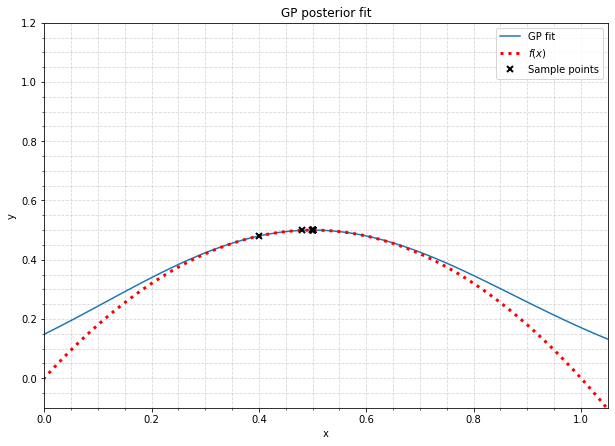

In [270]:
#First plot
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
ax.plot(Xnew, mean[:,0], "-")
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_title("GP posterior fit")

#Second plot
ax.plot(Xnew, f(Xnew),"r:", lw=3);
ax.legend(labels=["GP fit","$f(x)$"]);

#Third plot
training_points = (X,Y)
if training_points is not None:
    X_, Y_ = training_points
    ax.plot(X_, Y_, "kx", mew=2)
    ax.legend(labels=["GP fit","$f(x)$", "Sample points"])

# Organize plot
ax.minorticks_on()
ax.grid(which='minor', alpha=0.5, ls='--')
ax.grid(which='major', alpha=0.5, ls='--')
ax.set_xlim(left=0,right=1.05);
ax.set_ylim(bottom=-0.1, top=1.2);

#### Background on Functional Analysis: Function, Metric, and Lp Spaces
A function space is a vector space whose vectors are functions. (more info: http://www.math.usm.edu/lambers/mat415/lecture1.pdf)

2) Let $f$ be the 1D logisitc map and $g$ be the corresponding GP fit regression model which approximates $f$ using a set of sample points. We compute the $L_2[0,1]$ norm of the difference between $f$ and $g$:
$$\left\| f-g \right\|_2 = \sqrt{\int_0^1(f(x)-g(x))^2 dx}$$


In [271]:
#L2Norm = np.sqrt()
integrand = lambda x: (f(x) - GP_Predict_Point(x))**2
L2Norm = np.sqrt(integrate.quad(integrand, 0, 1))
print(L2Norm)

[5.53336383e-02 6.58659521e-07]


3) Figure: The plot on the left shows the cobweb of the GP regression fit (solid line) in comparison to the cobweb of $f$ (dotted line) with borth orbits starting at $x_0$. The plot on the right shows the time series of $x_n$ versus $n$, where $n$ is the $n$-th iteration of the one-dimensional map $f$.

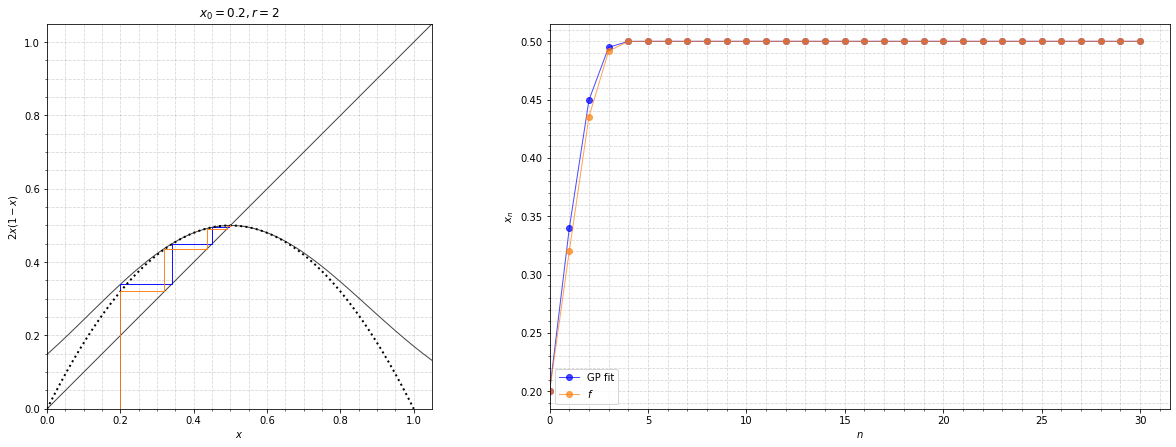

In [272]:
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

# First Plot
nmax = 30
r0 = r
x0 = 0.2
plot_cobweb_GP(r0,x0,fig,ax,bx)

# Second Plot on top
plot_cobweb_f(r0,x0,fig,ax,bx)

bx.legend(labels=["GP fit", "$f$"]);
plt.subplots_adjust(wspace=0)
plt.show()

4) To measure the dissimilarity between the two orbits, we compute the Hausdorff distance.

In [273]:
Hausdorff(x0,nmax,m,f)

0.027671972745759322

### Experiment 1 a) 

Setup Parameters

In [362]:
Nmax = 10 # max number of sample points
Nmin = 2
#--------------------
r1 = np.linspace(0.01, 3, 50)
r2 = np.linspace(3.01, 3.43, 50)
r3 = np.linspace(3.431, 3.45, 200)
r4 = np.linspace(3.451, 3.54, 50)
r5 = np.linspace(3.541, 3.56, 50)
r6 = np.linspace(3.561, 3.565, 50)
r7 = np.linspace(3.5651,3.5699, 200)
r8 = np.linspace(3.56991,3.5699461, 200)
r9 = np.linspace(3.569947,4,250)
r_range = np.concatenate((r1,r2,r3,r4,r5,r6,r7,r8,r9)) # range of r values
#-------------------
# choose one: 
x0_range = np.linspace(0.01,0.99,20)
#x0_i = 0.2 # initial orbit position for cobweb
#------------------
# for time series dist only -> choose one:
#x0_time_dist_range = np.linspace(0.01,0.99,20)
x0_time_dist_i = 0.4 # time series dist x0 starting value
#------------------
nmax = 30 # max iterations of orbit for Hausdorff dist. calculation

Experiment:

In [363]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
result = []
N_Array = []
R = []
H = []

# -- Approximate Calculation Time: --
start_time = timeit.default_timer()

k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
f = lambda x: 4*x*(1-x)
X = time_series_dist(0.4,Nmax)[:,None]
#X,N = declump(X,Nmax,2);
sd = 0
ep = np.random.normal(0., sd, (Nmax,1))
Y = f(X) + ep
m = GPy.models.GPRegression(X, Y, k)
m.constrain_positive(warning=False)
m.Gaussian_noise.variance = sd**2
m.Gaussian_noise.variance.fix()
m.optimize()
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
#--------
h = Hausdorff(0.2,nmax,m,f)
#--------
R.append(4)
H.append(h)
X0_Array = [R,H]
N_Array.append(X0_Array)
result.append(N_Array)

elapsed = timeit.default_timer() - start_time
multiplier = (Nmax-Nmin) * len(x0_range) * len(r_range)
print(str(multiplier) + " x " + str(elapsed) + " seconds.")
elapsed = elapsed * multiplier
print("Approximate calculation time needed: " + str(elapsed) + " seconds = " + str(elapsed/60) + " minutes = " + str(elapsed/3600) + " hours.")
print("Approximate calculation time needed: " + str(np.floor(elapsed/3600)) + " hrs, " + str(np.floor((elapsed/3600-np.floor(elapsed/3600))*60)) + " min, " + str(((elapsed/3600-np.floor(elapsed/3600))*60 - np.floor((elapsed/3600-np.floor(elapsed/3600))*60))*60) + " sec.")

176000 x 0.23355370000354014 seconds.
Approximate calculation time needed: 41105.451200623065 seconds = 685.0908533437178 minutes = 11.418180889061963 hours.
Approximate calculation time needed: 11.0 hrs, 25.0 min, 5.451200623067365 sec.


In [361]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

result = []
for n_i in range(Nmin,Nmax + 1):
    N_Array = []
    for x0_i in x0_range:
        R = []
        H = []
        for r_i in r_range:
            k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
            # -- Recalculate GP fit: -- 
            f = lambda x: r_i*x*(1-x)
            X = time_series_dist(x0_time_dist_i,n_i)[:,None]
            #X,N = declump(X,n_i,2);
            sd = 0
            ep = np.random.normal(0., sd, (n_i,1))
            Y = f(X) + ep
            m = GPy.models.GPRegression(X, Y, k)
            m.constrain_positive(warning=False)
            m.Gaussian_noise.variance = sd**2
            m.Gaussian_noise.variance.fix()
            m.optimize()
            mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
            #--------
            h = Hausdorff(x0_i,nmax,m,f)
            #--------
            R.append(r_i)
            H.append(h)
        X0_Array = [R,H]
        N_Array.append(X0_Array)
    result.append(N_Array)

[[[[0.01, 2.005, 4.0], [9.517120407308181e-05, 0.19729761632365747, 1.405383521966406]], [[0.01, 2.005, 4.0], [0.0008940565255937327, 0.007252315172931907, 0.590749385164618]], [[0.01, 2.005, 4.0], [0.00010912999403523423, 0.688055431206121, 0.93500284386192]]], [[[0.01, 2.005, 4.0], [8.46081521529721e-05, 0.09947383563073933, 0.1923092735391409]], [[0.01, 2.005, 4.0], [0.0006014764408294658, 5.2833790258221265e-06, 0.5645050674767729]], [[0.01, 2.005, 4.0], [0.00011936857901318923, 0.22565650237577262, 0.3677398692297963]]], [[[0.01, 2.005, 4.0], [8.553221765236162e-05, 0.09947383563073933, 0.0895849951650865]], [[0.01, 2.005, 4.0], [0.0005747009726533396, 2.6365317923917424e-06, 0.5485816135305536]], [[0.01, 2.005, 4.0], [0.00011271378539451145, 0.2254022944150754, 0.13307910531641892]]]]
